# Support Vector Machines

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Η λογική των Μηχανών Διανυσμάτων Υποστήριξης


Με τον Αφελή Μπεϋζιανό ταξινομητή είδαμε ένα παράδειγμα παραμετρικού μοντέλου το οποίο περιγράφει τις υποκείμενες κατανομές των δεδομένων προκειμένου να τα αποδώσει σε κλάσεις. Αυτή η κατηγορία ταξινομητών είναι η παραγωγική ή δημιουργική (generative). Τα SVM ανήκουν σε μια διαφορετική κατηγορία, στους μη-παραμετρικούς, διαχωριστικούς (discriminative) ταξινομητές οι οποίοι αντί να προσπαθούν να βρουν τις υποκείμενες κατανομές (δηλαδή της παραμέτρους τους) επιδιώκουν να βρουν μια ευθεία ή καμπύλη (σε δύο διαστάσεις) ή πολύπτυχο (manifold) σε περισσότερες τα οποία να διαχωρίζουν / διακρίνουν τις κατηγορίες μεταξύ τους. 

Σημειώστε ότι τα SVM είναι εγγενώς δυαδικοί ταξινομητές σε αντιδιαστολή πχ με τα MLP, ωστόσο υπάρχουν τεχνικές και επεκτάσεις για προβλήματα πολλών κλάσεων.

Ας εξετάσουμε πρώτα μια απλή περίπτωση ταξινόμησης στην οποία οι δύο κλάσεις δεδομένων (σημείων) είναι εύκολα διαχωρίσιμες.

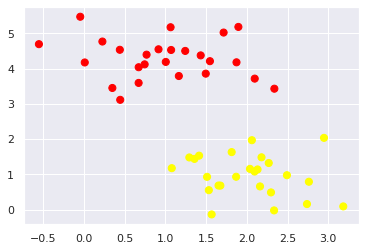

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Ένας γραμμικός διαχωριστικός ταξινομητής θα προσπαθήσει να φτιάξει μια ευθεία γραμμή η οποία θα διαχωρίζει τα δύο σύνολα δεδομένων, δημιουργώντας έτσι ένα μοντέλο ταξινόμησης (ο ορισμός μιας ευθείας είναι ο ορισμός της γενίκευσης). Για την απλή περίπτωση που εξετάζουμε θα μπορούσαμε εύκολα να βρούμε μια τέτοια ευθεία. Ωστόσο, αμέσως ανακαλύπτουμε ένα πρόβλημα: υπάρχουν περισσότερες από μια ευθείες, υπάρχουν μάλιστα άπειρες ευθείες που διαχωρίζουν τέλεια τις δύο κλάσεις.

Μπορούμε να σχεδιάσουμε κάποιες από αυτές ως εξής:

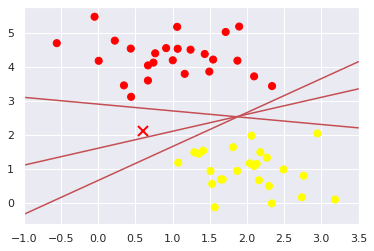

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-r')

plt.xlim(-1, 3.5);

Οι κόκκινες ευθείες ορίζουν τρεις πολύ διαφορετικές διαχωριστικές ευθείες - διαχωριστικούς ταξινομητές οι οποίοι διακρίνουν όλοι τέλεια τα δείγματα των δύο κλάσεων του συνόλου εκπαίδευσης.

Το πρόβλημα διαπιστώνεται κατά τη γενίκευση: ανάλογα με το ποια διαχωριστική ευθεία θα επιλέξετε, αν εμφανιστεί ένα νέο δείγμα-σημείο από το σύνολο δεδομένων ελέγχου (π.χ. αυτό που σημειώνεται με το "X" σε αυτό το γράφημα), είναι πιθανό να εκχωρηθεί σε μια διαφορετική ετικέτα, ανάλογα την ευθεία.
Προφανώς, η απλή ιδέα μας για τη «διαμόρφωση μιας διαχωριστικής ευθείας μεταξύ των κλάσεων» δεν είναι επαρκής και πρέπει να σκεφτούμε λίγο πιο σύνθετα.

## Μηχανές Διανυσμάτων Υποστήριξης: μεγιστοποιώντας το περιθώριο

Τα SVM προσφέρουν μια μέθοδο για να βελτιώσουμε την απόφασή μας. Η ιδέα είναι η εξής: αντί να σχεδιάσουμε ευθείες μηδενικού πλάτους, μπορούμε να σχεδιάσουμε γύρω από κάθε ευθεία ένα περιθώριο κάποιου πλάτους, το οποίο θα φτάνει μέχρι το κοντινότερο σημείο.  
Στο παράδειγμά μας θα ήταν κάπως έτσι:

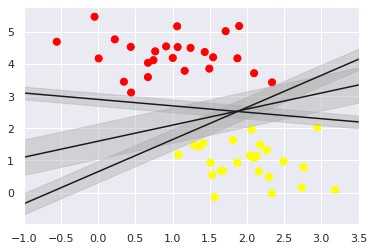

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Στα SVM η γραμμή που μεγιστοποιεί το περιθώριο είναι αυτή που θα επιλεχθεί ως το βέλτιστο μοντέλο. Τα SVM είναι ένα παράδειγμα εκτιμητή μεγιστοποίησης του περιθωρίου (maximum margin estimator).

### Προσαρμογή (εκπαίδευση) των SVM

Ας δούμε ένα παράδειγμα πραγματικής εκπαίδευσης SVM σε αυτά τα δεδομένα.
Προς το παρόν, θα χρησιμοποιήσουμε έναν γραμμικό πυρήνα και θα ορίσουμε μια πολύ μεγάλη τιμή για την παράμετρο `C`

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Για να οπτικοποιήσουμε καλύτερα το τί συμβαίνει εδώ, ας ορίσουμε για ευκολία μια συνάρτηση που σχεδιάζει τα όρια των αποφάσεων του SVM μας:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

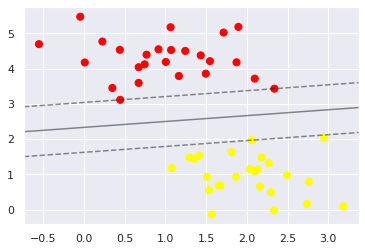

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Αυτή είναι η διαχωριστική γραμμή που μεγιστοποιεί το περιθώριο μεταξύ των δύο κλάσεων.
Παρατηρήστε ότι μερικά από τα σημεία εκπαίδευσης αγγίζουν το περιθώριο: υποδεικνύονται από τους μαύρους κύκλους στο σχήμα.
Αυτά τα σημεία είναι τα κεντρικά στοιχεία αυτής της προσαρμογής, τα αποκαλούμε διανύσματα υποστήριξης και δίνουν στον αλγόριθμο το όνομά του.
Στο Scikit-Learn, η θέση των διανυσμάτων υποστήριξης αποθηκεύεται στην ιδιότητα ``support_vectors_`` του ταξινομητή:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Ένα σημαντικό χαρακτηριστικό του ταξινομητή είναι ότι μόνο η θέση των διανυσμάτων υποστήριξης έχει σημασία για την εύρεση της βέλτιστης ευθείας. Τυχόν σημεία, μακριά από το περιθώριο, τα οποία βρίσκονται στη σωστή πλευρά δεν επηρεάζουν την εκπαίδευση. Τεχνικά, αυτό οφείλεται στο γεγονός ότι αυτά τα σημεία δεν συμβάλλουν στη συνάρτηση σφάλματος (loss function) που χρησιμοποιείται για να προσαρμοστεί το μοντέλο, επομένως η θέση και ο αριθμός τους δεν έχουν σημασία όσο δεν υπερβαίνουν το περιθώριο.

Αυτό μπορούμε να το δούμε, για παράδειγμα, αν σχεδιάσουμε το μοντέλο που μάθαμε από τα πρώτα 60 σημεία και από τα πρώτα 120 σημεία αυτού του συνόλου δεδομένων:

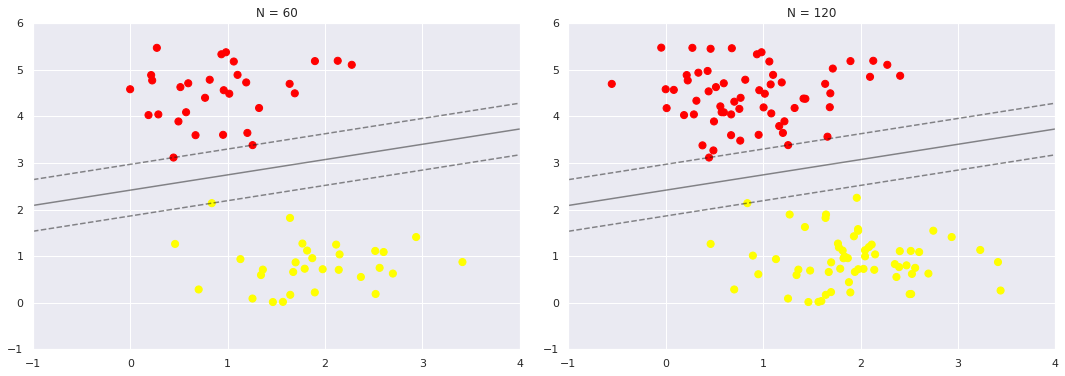

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

Στο αριστερά, βλέπουμε το μοντέλο και τα διανύσματα υποστήριξης για 60 σημεία εκπαίδευσης. Στα δεξιά, έχουμε διπλασιάσει τον αριθμό των σημείων εκπαίδευσης, αλλά το μοντέλο δεν έχει αλλάξει: τα τρία διανύσματα υποστήριξης από το αριστερό γράφημα εξακολουθούν να είναι τα διανύσματα υποστήριξης και στο δεξί.

Αυτή η “αναισθησία” στην ακριβή συμπεριφορά των απομακρυσμένων σημείων είναι ένα από τα πλεονεκτήματα του μοντέλου SVM.

Στα notebooks μπορούμε να δούμε και διαδραστικά αυτή την ιδιότητα χρησιμοποιώντας τα widgets του IPython:

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Widget Javascript not detected.  It may not be installed or enabled properly.


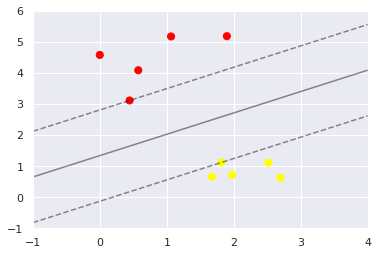

In [10]:
from ipywidgets import interact, fixed
!jupyter nbextension enable --py widgetsnbextension
interact(plot_svm, N=[10, 100, 200, 400], ax=fixed(None));

### Πέρα από τα γραμμικά διαχωρίσιμα προβλήματα: Kernel SVM

Τα SVM γίνονται εξαιρετικά ισχυρά όταν συνδυάζονται με πυρήνες (kernels)

Συναρτήσεις πυρήνων (kernel functions): αποκαλούμε συναρτήσεις πυρήνα ή απλά πυρήνες, συναρτήσεις που ορίζουν το εσωτερικό γινόμενο (ομοιότητα) μεταξύ δύο διανυσμάτων εισόδου σε έναν άλλο διανυσματικό χώρο, συχνά πολύ μεγαλύτερων (ή και άπειρων). διαστάσεων 

Για να δούμε τη χρησιμότητα των πυρήνων στα SVM ας δούμε μερικά δεδομένα που δεν είναι γραμμικά διαχωρίσιμα:

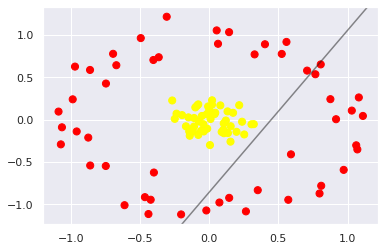

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Είναι προφανώς ότι δεν μπορεί να γίνει γραμμικός διαχωρισμός στα δεδομένα αυτά. Μια συνηθισμένη τεχνική σε τέτοιες περιπτώσεις είναι να προβάλλουμε τα δεδομένα σε υψηλότερες διαστάσεις έτσι ώστε ένας γραμμικός διαχωριστής να είναι επαρκής.

Για παράδειγμα, μια απλή προβολή που θα μπορούσαμε να χρησιμοποιήσουμε θα ήταν να υπολογίσουμε μια συνάρτηση ακτινική βάσης (radial basis function - RBF)

![](https://miro.medium.com/max/1260/1*izqr1xGcP89B7Xs1EluIQQ.png)

 με επίκεντρο τη μεσαία συστάδα δηλαδή center = (0,0):

In [12]:
r = np.exp(-(X ** 2).sum(1))

Θυυμηθείτε ότι $||\boldsymbol {x}||_{2}:={\sqrt {x_{1}^{2}+\cdots +x_{n}^{2}}}$ άρα τελικά έχουμε το άθροισμα των τετραγώνων όλων των διαστάσεων. Στην απλή αυτή περίπτωση λαμβάνουμε $γ=1$.

![RBF](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/Gaussian_2d.svg/300px-Gaussian_2d.svg.png)

Μπορούμε να οπτικοποιήσουμε την πρόσθετη διάσταση με ένα τρισδιάστατο γράφημα. Εντός notebooks μπορούμε να χρησιμοποιήσουμε τα sliders για να περιστρέψουμε το γράφημα:

Widget Javascript not detected.  It may not be installed or enabled properly.


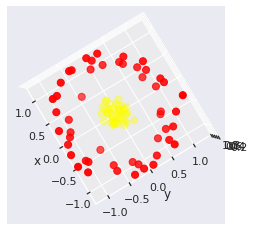

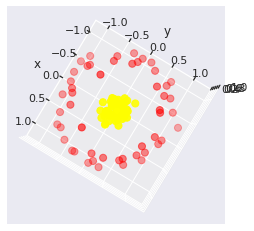

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

Μπορούμε να δούμε ότι με αυτήν την πρόσθετη διάσταση, τα δεδομένα καθίστανται γραμμικά διαχωρίσιμα, σχεδιάζοντας για παράδειγμα ένα διαχωριστικό επίπεδο στο, ας πούμε, r = 0,7 (άξονας του z).

Πρέπει να επιλέξουμε προσεκτικά την προβολή μας: εάν δεν είχαμε “κεντράρει” τη συνάρτηση ακτινικής βάσης στη σωστή θέση, δεν θα είχαμε δει καθαρά, γραμμικά διαχωρίσιμα αποτελέσματα. Γενικά, η ανάγκη να κάνουμε μια τέτοια καλή επιλογή είναι πρόβλημα: θα θέλαμε να μπορούμε να βρούμε αυτόματα τις καλύτερες ακτινικές συναρτήσεις βάσης.

Μία στρατηγική προς το σκοπό αυτό είναι να υπολογιστεί μια συνάρτηση βάσης που επικεντρώνεται σε κάθε σημείο του συνόλου δεδομένων και να αφήσουμε τον αλγόριθμο SVM να διαλέξει τα αποτελέσματα. Αυτός ο τύπος μετασχηματισμού συνάρτησης βάσης είναι γνωστός ως μετασχηματισμός πυρήνα, καθώς βασίζεται στη σχέση ομοιότητας (ή πυρήνα) μεταξύ κάθε ζεύγους σημείων.

Ένα πιθανό πρόβλημα με αυτήν τη στρατηγική δηλαδή την προβολή $ N $ σημείων σε $ N $  διαστάσεις (όπου κάθε πρόβλημα γίνεται διαχωρίσιμο) είναι ότι μπορεί να γίνει πολύ ακριβή υπολογιστικά καθώς το $ N $ μεγαλώνει.

Ωστόσο, χάρη σε μια πολύ βολική ιδιότητα γνωστή ως [kernel trick](https://en.wikipedia.org/wiki/Kernel_trick), η εκπαίδευση με δεδομένα που έχουν μετασχηματιστεί από την συνάρτηση πυρήνα σε πολύ μεγάλες διαστάσεις μπορεί να γίνει σιωπηρά, δηλαδή χωρίς ποτέ να υπολογίσουμε την πλήρη αναπαράσταση των διανυσμάτων στον χώρο προβολής του πυρήνα υψηλών διαστάσεων $ Ν $. Τα SVM βασίζονται στο kernel trick για την επίλυση μη γραμμικών προβλημάτων με προβολή σε χώρους υψηλής διαστατικότητας.

Στο Scikit-Learn, μπορούμε να εφαρμόσουμε μετασχηματισμού πυρήνα στα SVM απλά αλλάζοντας τον γραμμικό μας πυρήνα σε έναν πυρήνα RBF (συνάρτηση ακτινικής βάσης), χρησιμοποιώντας την υπερπαράμετρο `kernel` του μοντέλου.

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

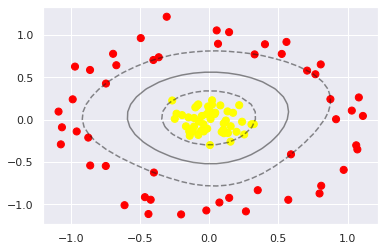

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Χρησιμοποιώντας αυτό το “κόλπο” με τα SVM, μπορούμε να μάθουμε ένα κατάλληλο μη γραμμικό όριο αποφάσεων (στο αρχικό χώρο των διανυσμάτων).
Αυτή η στρατηγική μετασχηματισμού πυρήνα χρησιμοποιείται συχνά στη μηχανική μάθηση για να μετατρέψει γρήγορες γραμμικές μεθόδους σε γρήγορες μη γραμμικές μεθόδους, ειδικά σε μοντέλα στα οποία μπορεί να χρησιμοποιηθεί το κόλπο του πυρήνα.

### Ρύθμιση των SVM: μαλακό περιθώριο

Μέχρι στιγμής επικεντρώθηκε σε πολύ καθαρά σύνολα δεδομένων, στα οποία υπάρχει ένα τέλειο όριο αποφάσεων.
Τι γίνεται όμως αν τα δεδομένα μας έχουν κάποια αλληλεπικάλυψη;
Για παράδειγμα, μπορεί να έχετε δεδομένα όπως αυτό:

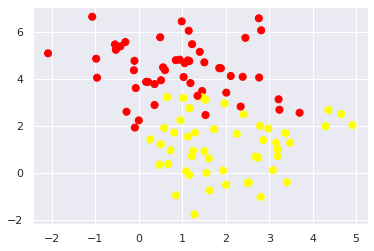

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Για να χειριστεί αυτήν την περίπτωση, η υλοποίηση των SVM έχει μια ιδιότητα που "μαλακώνει" το περιθώριο: επιτρέπει δηλαδή σε ορισμένα από τα σημεία να περάσουν στο περιθώριο εάν αυτό επιτρέπει καλύτερη προσαρμογή.
Η σκληρότητα του περιθωρίου ελέγχεται από μια υπερπαράμετρο, πιο συχνά γνωστή ως $ C $ (από το “Cost”).
Για πολύ μεγάλα $ C $, το περιθώριο είναι σκληρό και δεν μπορούν να βρεθούν 
καθόλου σημεία εντός του περιθωρίου.
Για μικρότερα $ C $, το περιθώριο είναι πιο μαλακό και μπορεί να συμπεριλάβει εντός του κάποια σημεία.

Το διάγραμμα που φαίνεται παρακάτω δίνει μια οπτική εικόνα για το πώς η μεταβαλλόμενη υπερπαράμετρος $ C $ επηρεάζει την τελική λειτουργία του ταξινομητή, μέσω της εξασθένισης του περιθωρίου:

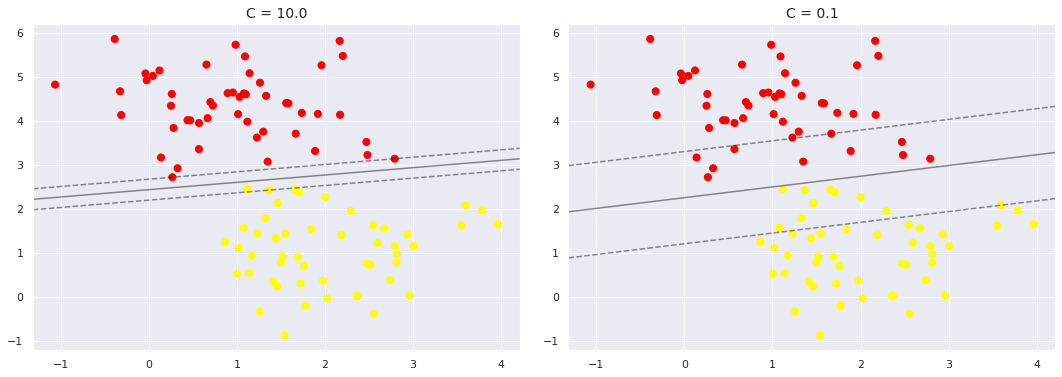

In [17]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Η εύρεση του βέλτιστου $C$, όπως για όλες τις υπερπαραμέτρους, γίνεται με διασταυρούμενη επικύρωση (cross-validation). 
Αντιλαμβανόμαστε ότι τo $C$ είναι βέβαια μια παράμετρος ομαλοποίησης (regularization). Μεγάλο $C$ σημαίνει μεγάλη πόλωση (bias) όπου δεν αφήνουμε καθόλου λάθος ταξινομημένα δείγματα, πιθανώς οδηγώντας σε στενό μέγιστο περιθώριo, υπερεκπαίδευση και όχι καλή γενίκευση. Αντιθετοαντίστροφα, πολύ μικρό $C$ σημαίνει ότι επιτρέπουμε μεγάλα μέγιστα περιθώρια με πολλά δείγματα εντός του περιθωρίου

## Εφαρμογή: Επιβεβαίωση προσώπων (Face verification)


Για να δούμε τα SVM στην πράξη, θα εξετάσουμε ένα πρόβλημα επιβεβαίωσης προσώπων. Σημειώστε ότι αυτό είναι ένα διαφορετικό πρόβλημα από την αναγνώριση προσώπων (face recognition). Στην αναγνώριση θέλουμε να εντοπίσουμε τα πρόσωπα εντός μιας φωτογραφίας (την περιοχή που τα περικλύει, στην επιβεβαίωση έχουμε μόνο πρόσωπα εντός της εικόνας και θέλουμε βρούμε σε ποιον ανήκει το πρόσωπο.

Θα χρησιμοποιήσουμε το σύνολο δεδομένων [“Labeled Faces in the Wild”](http://vis-www.cs.umass.edu/lfw/), το οποίο αποτελείται από αρκετές χιλιάδες συγκεντρωμένες φωτογραφίες διαφόρων δημόσιων προσώπων. Το σύνολο δεδομένων είναι ενσωματωμένο στο Scikit-Learn:

In [24]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

Ας τυπώσουμε μερικές εικόνες για να δούμε με τι δουλεύουμε: 

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Κάθε εικόνα περιέχει [62 × 47] ή αλλιώς 2914 εικονοστοιχεία (pixels). Θα μπορούσαμε να προχωρήσουμε απλά χρησιμοποιώντας κάθε τιμή pixel ως χαρακτηριστικό, αλλά συχνά είναι πιο αποτελεσματικό να χρησιμοποιούμε κάποιο είδος προεπεξεργαστή για την εξαγωγή των περισσότερο σημαντικών χαρακτηριστικών. Εδώ θα χρησιμοποιήσουμε τη γνωστή μας ανάλυση σε κύριες συνιστώσες. Θα “πακετάρουμε” τον προεπεξεργαστή και τον ταξινομητή σε ένα pipeline:

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(whiten=True)
svc = SVC(class_weight='balanced')
model = make_pipeline(pca, svc)

Κατά τα γνωστά, διαχωρίζουμε σε train και test set:

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target)

Θα χρησιμοποιήσουμε διασταυρούμενη επικύρωση πλέγματος για να διερευνήσουμε τους συνδυασμούς όλων των υπερπαραμέτρων. Σημειώστε ότι και το είδος της συνάρτησης πυρήνα είναι υπερπαράμετρος και ότι η βιβλιοθήκη είναι αρκετά “έξυπνη” για να καταλάβει ότι ο γραμμικός πυρήνας δεν έχει πάραμετρο $γ$.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'pca__n_components': [80, 100],
              'svc__kernel': ['linear', 'rbf'],
              'svc__C': [40, 50, 60],
              'svc__gamma': [0.00025, 0.0005, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Η υπερπαράμετρος $γ$ ελέγχει το μήκος της ακτίνας των RBF. Μεγάλο $γ$ δημιουργεί στενές και ψηλές RBF, μικρός $γ$ πλατιές και χαμηλές.

![](https://miro.medium.com/max/2400/1*r9CO-gp1uuRsYooCLL9UeQ.png)

Η εύρεση του βέλτιστου $γ$ είναι σημαντική για την σωστή εκπαίδευση SVM με πυρήνα RBF (αποφυγή υποπροσαρμογής - υπερπροσαρμογής). 


Συνεχίζοντας, οι βέλτιστες τιμές πέφτουν προς τη μέση του πλέγματος μας. Αν έπεφταν στα άκρα, θα έπρεπε να επεκτείνουμε το πλέγμα για να βεβαιωθούμε ότι βρήκαμε το πραγματικό βέλτιστο.

Μπορούμε πλέον να προβλέψουμε τις ετικέτες στα δεδομένα ελέγχου, τα οποία το μοντέλο δεν έχει δει ακόμη, ώστε να λάβουμε ένα μέτρο της ικανότητας γενίκευσής του:

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Ας ρίξουμε μια ματιά σε μερικές από εικόνες του test set μαζί με τις προβλεπόμενες ετικέτες τους:

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Για τη συνολική αξιολόγηση της απόδοσης του ταξινομητή θα χρησιμοποιήσουμε το γνωστό μας `classification_report`:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

Τυπώνουμε επίσης τον πίνακα σύγχυσης (confusion matrix):

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Ο πίνακας σύγχυσης μας βοηθά να κατανοήσουμε ποιες ετικέτες είναι πιθανό να συγχέονται από τον εκτιμητή. 

Η εφαρμογή που κάναμε είναι πολύ απλή. Μια σοβαρότερη εφαρμογή θα χρησιμοποιούσε την de facto βιβλιοθήκη όρασης υπολογιστών [OpenCV](http://opencv.org) για την εξαγωγή χαρακτηριστικών.

## Support Vector Machines: Σύνοψη

Στο notebook αυτό κάναμε μια διαισθητική εισαγωγή στις αρχές πίσω από τις μηχανές διανυσμάτων υποστήριξης.

Τα SVM είναι μια ισχυρή μέθοδος ταξινόμησης για διάφορους λόγους:

- Η εξάρτησή τους από σχετικά λίγα διανύσματα υποστήριξης σημαίνει ότι είναι πολύ συμπαγή μοντέλα και καταλαμβάνουν πολύ λίγη μνήμη.
- Εφόσον εκπαιδευτεί το μοντέλο, η φάση πρόβλεψης είναι πολύ γρήγορη. Συγκρίνετε με ταξινομητές βασισμένους σε στιγμιότυπα (instance-based) όπως ο kNN όπου για κάθε δείγμα του test πρέπει να υπολογίσουμε την απόστασή από όλα τα σημεία του train.
- Επειδή επηρεάζονται μόνο από σημεία κοντά στο περιθώριο, λειτουργούν καλά με δεδομένα υψηλών διαστάσεων - ακόμη και δεδομένα με περισσότερες διαστάσεις από ότι δείγματα, κάτι που αποτελεί πρόκληση για άλλους αλγόριθμους.
- Η ενσωμάτωσή τους με μεθόδους πυρήνα τα καθιστά πολύ ευέλικτα, ικανά να προσαρμοστούν σε πολλούς τύπους δεδομένων.

Ωστόσο, τα SVM έχουν επίσης και αρκετά μειονεκτήματα:

- Η κλιμάκωση με τον αριθμό των δειγμάτων $ N $ είναι στη χειρότερη $ {O} [N ^ 3] $ και  $ {O} [N ^ 2] $ για αποτελεσματικές υλοποιήσεις. Για μεγάλο αριθμό δειγμάτων εκπαίδευσης, αυτό το υπολογιστικό κόστος μπορεί να είναι απαγορευτικό. Μια εναλλακτική λύση είναι η χρήση της παραλλαγής SMO (Sequential Minimal Optimization) των SVM. Η SMO σπάει το πρόβλημα βελτιστοποίησης των SVM σε πολλά μικρότερα προβλήματα, πιο εύκολα επιλύσιμα. Η SMO δεν υποστηρίζεται από το scikit, αλλά υποστηρίζεται από την "canonical" βιβλιοθήκη SVM, την [LIBSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvm/). Περισσότερα για την SMO [link1](https://jonchar.net/notebooks/SVM/), [link2](http://chubakbidpaa.com/svm/2020/12/27/smo-algorithm-simplifed-copy.html). 

- Τα αποτελέσματα εξαρτώνται σε μεγάλο βαθμό από την κατάλληλη επιλογή για την παράμετρο μαλακώματος $ C $. Αυτό πρέπει να γίνει μόνο με cross-validation ή οποία μπορεί να είναι ακριβή υπολογιστικά αν έχουμε πολλά δεδομένα.
- Τα αποτελέσματα δεν έχουν άμεση πιθανοτική ερμηνεία (κατά πόσο ένα δείγμα ανήκει σε μία κλάση), όπως θα είχαμε σε ένα MLP με συνάρτηση ενεργοποίησης softmax στην έξοδο ή όπως έχουμε στη λογιστική παλινδρόμηση (logistic regression). Σε κάποιες περιπτώσεις SVM αυτό μπορεί να εκτιμηθεί μέσω μιας εσωτερικής διασταυρούμενης επικύρωσης (δείτε την παράμετρο "probability" του "SVC"), αλλά αυτή η επιπλέον εκτίμηση είναι υπολογιστικά δαπανηρή.

Λαμβάνοντας υπόψη τα ανωτέρω χαρακτηριστικά, γενικά στρεφόμαστε στα SVMs όταν άλλες απλούστερες, ταχύτερες και λιγότερο απαιτητικές μέθοδοι έχουν αποδειχθεί ανεπαρκείς για τις ανάγκες του προβλήματος.

Ωστόσο, εάν έχετε επαρκείς υπολογιστικούς πόρους για να δεσμεύσετε στην εκπαίδευση και την επικύρωση ενός SVM στα δεδομένα σας, η μέθοδος μπορεί να οδηγήσει σε εξαιρετικά αποτελέσματα.

# Τα είδη των ταξινομητών

Έχουμε πλέον εξετάσει διάφορους ταξινομητές έτσι ώστε να μπορούμε να τους κατατάξουμε σε τρεις κατηγορίες, σύμφωνα με το επόμενο σχήμα.

![](https://i2.paste.pics/8569adc1d80d3b5a37188897ac0375aa.png)